In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.0


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


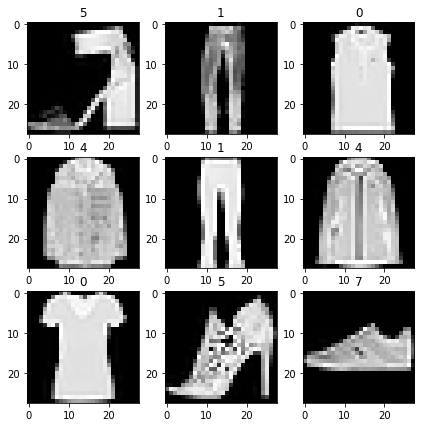

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

plt.figure(figsize=(7, 7))
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainY[i])
plt.show()

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [8]:
random_input = tensorflow.keras.layers.Input(shape = 500)
class_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(5*5*255)(random_input)
x1 = tensorflow.keras.layers.Activation('swish')(x1)
x1 = tensorflow.keras.layers.Reshape((5, 5, 255))(x1)

#Class Input
x2 = tensorflow.keras.layers.Dense(25)(class_input)
x2 = tensorflow.keras.layers.Activation('swish')(x2)
x2 = tensorflow.keras.layers.Reshape((5, 5, 1))(x2)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, class_input], outputs=generated_image)
generator_network.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6375)         3193875     input_5[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 25)           275         input_6[0][0]                    
_______________________________________________________________________________________

# Discriminator

In [9]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))
class_input = tensorflow.keras.layers.Input(shape = 10)

#Class Input
x2 = tensorflow.keras.layers.Dense(28*28)(class_input)
x2 = tensorflow.keras.layers.Activation('swish')(x2)
x2 = tensorflow.keras.layers.Reshape((28, 28, 1))(x2)

x = tensorflow.keras.layers.Concatenate()([image_input, x2])

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(32)(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[image_input, class_input], outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 784)          8624        input_8[0][0]                    
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 784)          0           dense_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
_______________________________________________________________________________________

In [10]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# GAN

In [11]:
discriminator_network.trainable=False
gan_input = generator_network([random_input, class_input])
gan_output = discriminator_network([gan_input, class_input])

gan_model = tensorflow.keras.models.Model([random_input, class_input], gan_output)
gan_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 28, 28, 1)    5627559     input_5[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 1)            1234097     functional_3[0][0]    

# Compiling GAN

In [12]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [13]:
indices = [i for i in range(0, len(trainX))]

def encode_class(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_class(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    class_names = []
    for i in range(batch_size):
        class_name = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        class_names.append(encode_class(class_name))
    class_names = np.array(class_names)
    return random_noise_batches, class_names

def get_fake_samples(generator_network, batch_size, noise_size, class_names=-1):
    random_noise_batches, _ = get_random_noise(batch_size, noise_size) 
    if class_names == -1:
        class_names = []
        for i in range(batch_size):
            class_name = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
            class_names.append(encode_class(class_name))
        class_names = np.array(class_names)
            
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_names])
    return [fake_samples, class_names]

def get_real_samples(batch_size, class_names=-1):
    if class_names == -1:
        random_indices = np.random.choice(indices, size=batch_size)
        class_names = []
        for ind in random_indices:
            class_names.append(encode_class(trainY[ind]))
        
    else:
        random_indices = []
        for cls in class_names:
            ind = np.random.choice(np.where(trainY==cls), size=1)
            random_indices.append(ind)

    real_images = trainX[np.array(random_indices),:]
    return [real_images, class_names]

def show_generator_results(generator_network):
    fake_samples = get_fake_samples(generator_network, 10, noise_size)
    # for i in range(0, len(fake_samples)):
    #     plt.imshow(fake_samples[i,:,:,-1], cmap='gray')
    #     plt.show()

    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = j
        plt.subplot(330 + 1 + j)
        plt.imshow(fake_samples[0][i,:,:,-1], cmap='gray')
        plt.title(decode_class(fake_samples[1][i]))
    plt.show()
    return

# Training GAN

In [14]:
tensorflow.config.run_functions_eagerly(True)

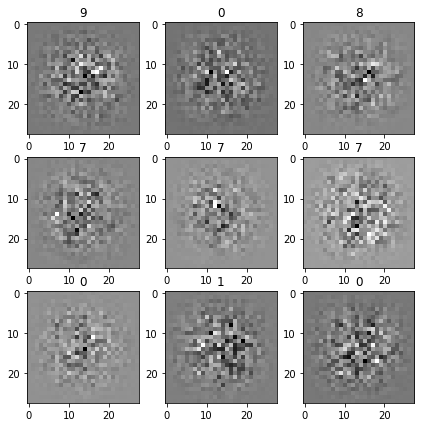

Epoch:0, Step:0, D-Loss:0.693, D-Acc:56.000, G-Loss:0.693
Epoch:0, Step:50, D-Loss:0.456, D-Acc:85.000, G-Loss:1.485
Epoch:0, Step:100, D-Loss:0.764, D-Acc:37.000, G-Loss:0.899
Epoch:0, Step:150, D-Loss:0.266, D-Acc:89.000, G-Loss:4.505
Epoch:0, Step:200, D-Loss:0.307, D-Acc:89.000, G-Loss:1.887
Epoch:0, Step:250, D-Loss:0.483, D-Acc:80.000, G-Loss:1.070
Epoch:0, Step:300, D-Loss:0.555, D-Acc:70.000, G-Loss:1.238
Epoch:0, Step:350, D-Loss:0.554, D-Acc:76.000, G-Loss:1.019
Epoch:0, Step:400, D-Loss:0.629, D-Acc:67.000, G-Loss:1.045
Epoch:0, Step:450, D-Loss:0.558, D-Acc:74.000, G-Loss:1.275
Epoch:1, Step:0, D-Loss:0.445, D-Acc:79.000, G-Loss:1.463
Epoch:1, Step:50, D-Loss:0.630, D-Acc:56.000, G-Loss:0.949
Epoch:1, Step:100, D-Loss:0.633, D-Acc:71.000, G-Loss:1.313
Epoch:1, Step:150, D-Loss:0.402, D-Acc:89.000, G-Loss:1.219
Epoch:1, Step:200, D-Loss:0.485, D-Acc:78.000, G-Loss:1.398
Epoch:1, Step:250, D-Loss:0.400, D-Acc:84.000, G-Loss:1.267
Epoch:1, Step:300, D-Loss:0.406, D-Acc:81.000,

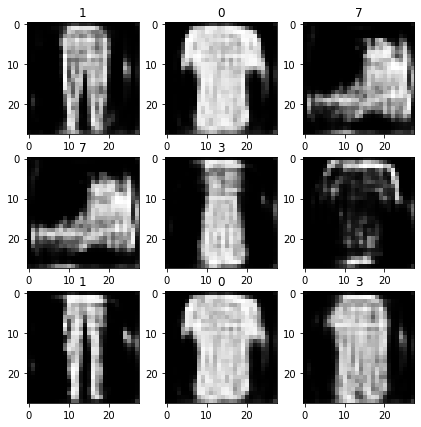

Epoch:10, Step:0, D-Loss:0.395, D-Acc:84.000, G-Loss:1.623
Epoch:10, Step:50, D-Loss:0.519, D-Acc:70.000, G-Loss:1.286
Epoch:10, Step:100, D-Loss:0.435, D-Acc:83.000, G-Loss:1.294
Epoch:10, Step:150, D-Loss:0.422, D-Acc:81.000, G-Loss:1.559
Epoch:10, Step:200, D-Loss:0.391, D-Acc:82.000, G-Loss:1.505
Epoch:10, Step:250, D-Loss:0.370, D-Acc:84.000, G-Loss:1.732
Epoch:10, Step:300, D-Loss:0.540, D-Acc:75.000, G-Loss:1.417
Epoch:10, Step:350, D-Loss:0.482, D-Acc:77.000, G-Loss:1.274
Epoch:10, Step:400, D-Loss:0.317, D-Acc:89.000, G-Loss:1.414
Epoch:10, Step:450, D-Loss:0.410, D-Acc:76.000, G-Loss:1.611
Epoch:11, Step:0, D-Loss:0.455, D-Acc:81.000, G-Loss:1.441
Epoch:11, Step:50, D-Loss:0.345, D-Acc:84.000, G-Loss:1.540
Epoch:11, Step:100, D-Loss:0.562, D-Acc:73.000, G-Loss:2.159
Epoch:11, Step:150, D-Loss:0.509, D-Acc:73.000, G-Loss:1.683
Epoch:11, Step:200, D-Loss:0.324, D-Acc:87.000, G-Loss:1.574
Epoch:11, Step:250, D-Loss:0.487, D-Acc:79.000, G-Loss:1.475
Epoch:11, Step:300, D-Loss:0.5

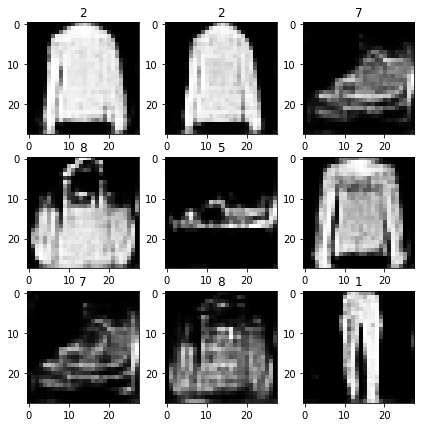

Epoch:20, Step:0, D-Loss:0.543, D-Acc:68.000, G-Loss:1.250
Epoch:20, Step:50, D-Loss:0.554, D-Acc:68.000, G-Loss:1.215
Epoch:20, Step:100, D-Loss:0.566, D-Acc:75.000, G-Loss:1.261
Epoch:20, Step:150, D-Loss:0.518, D-Acc:70.000, G-Loss:1.315
Epoch:20, Step:200, D-Loss:0.540, D-Acc:76.000, G-Loss:1.414
Epoch:20, Step:250, D-Loss:0.534, D-Acc:71.000, G-Loss:1.133
Epoch:20, Step:300, D-Loss:0.392, D-Acc:81.000, G-Loss:1.160
Epoch:20, Step:350, D-Loss:0.439, D-Acc:82.000, G-Loss:1.302
Epoch:20, Step:400, D-Loss:0.498, D-Acc:75.000, G-Loss:1.256
Epoch:20, Step:450, D-Loss:0.498, D-Acc:72.000, G-Loss:1.166
Epoch:21, Step:0, D-Loss:0.537, D-Acc:75.000, G-Loss:1.091
Epoch:21, Step:50, D-Loss:0.532, D-Acc:70.000, G-Loss:1.188
Epoch:21, Step:100, D-Loss:0.406, D-Acc:84.000, G-Loss:1.231
Epoch:21, Step:150, D-Loss:0.611, D-Acc:63.000, G-Loss:1.310
Epoch:21, Step:200, D-Loss:0.476, D-Acc:77.000, G-Loss:1.153
Epoch:21, Step:250, D-Loss:0.589, D-Acc:70.000, G-Loss:1.188
Epoch:21, Step:300, D-Loss:0.5

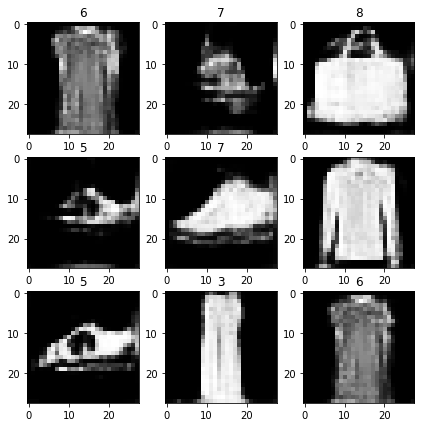

Epoch:30, Step:0, D-Loss:0.523, D-Acc:72.000, G-Loss:1.106
Epoch:30, Step:50, D-Loss:0.496, D-Acc:77.000, G-Loss:1.342
Epoch:30, Step:100, D-Loss:0.516, D-Acc:72.000, G-Loss:1.201
Epoch:30, Step:150, D-Loss:0.507, D-Acc:78.000, G-Loss:1.122
Epoch:30, Step:200, D-Loss:0.555, D-Acc:70.000, G-Loss:1.229
Epoch:30, Step:250, D-Loss:0.587, D-Acc:66.000, G-Loss:1.042
Epoch:30, Step:300, D-Loss:0.534, D-Acc:71.000, G-Loss:1.110
Epoch:30, Step:350, D-Loss:0.443, D-Acc:77.000, G-Loss:1.167
Epoch:30, Step:400, D-Loss:0.517, D-Acc:77.000, G-Loss:1.079


In [ ]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 500

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch_part1 = np.vstack((fake_samples[0], real_samples[0]))
        input_batch_part2 = np.vstack((fake_samples[1], real_samples[1]))
        
        input_batch_final = [input_batch_part1, input_batch_part2]
        
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch_final, output_labels)
        
        noise_batches, class_values = get_random_noise(batch_size, noise_size)
        gan_input = [noise_batches, class_values]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
            

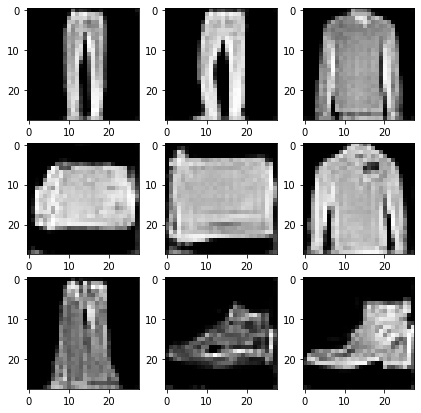

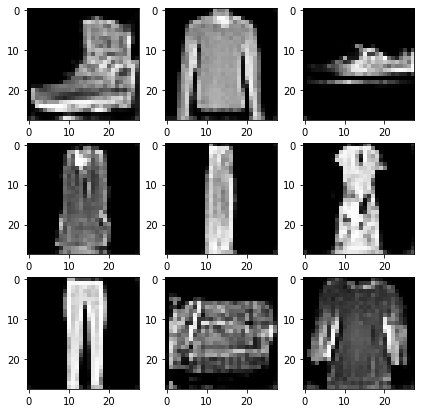

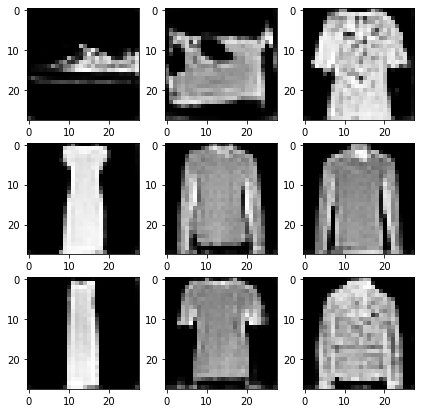

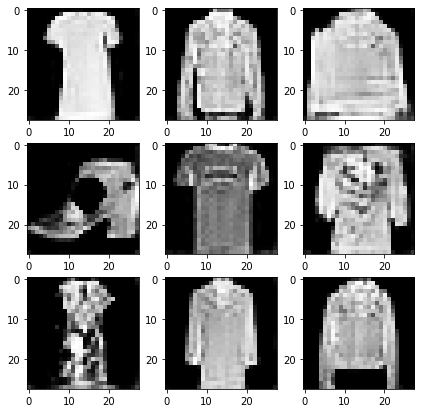

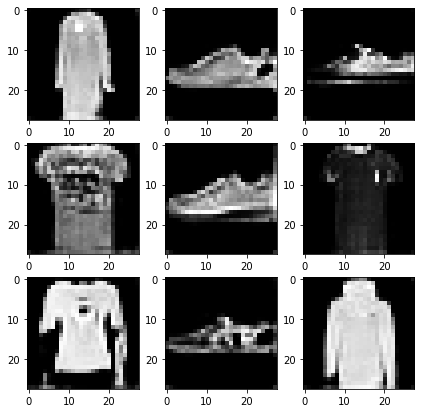

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)